In [1]:
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")
os.environ["NUMEXPR_NUM_THREADS"] = "10"

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
def find_optimal_silhouette(silhouette_scores):
    """Find the optimal number of clusters based on the maximum silhouette score."""
    optimal_clusters = (
        np.argmax(silhouette_scores) + 2
    )  # +2 because silhouette starts from 2 clusters
    return optimal_clusters


def find_optimal_davies_bouldin(db_scores):
    """Find the optimal number of clusters based on the minimum Davies-Bouldin score."""
    optimal_clusters = (
        np.argmin(db_scores) + 2
    )  # +2 because Davies-Bouldin starts from 2 clusters
    return optimal_clusters


def fit_kmeans(data_scaled, n_clusters, random_state=0):
    """Fit KMeans and return the model."""
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=random_state,
    )
    kmeans.fit(data_scaled)
    return kmeans


def evaluate_clustering(data_scaled, max_clusters=8, random_states=[0]):
    """Evaluate clustering using WCSS, silhouette scores, and Davies-Bouldin scores, across multiple random states."""
    wcss = np.zeros(max_clusters)
    silhouette_scores = np.zeros(
        max_clusters - 1
    )  # Silhouette scores start from 2 clusters
    db_scores = np.zeros(max_clusters - 1)  # Same for Davies-Bouldin scores

    for random_state in random_states:
        for i in range(1, max_clusters + 1):
            kmeans = fit_kmeans(data_scaled, i, random_state)
            wcss[i - 1] += kmeans.inertia_

            if (
                i > 1
            ):  # Silhouette and Davies-Bouldin scores require at least 2 clusters
                silhouette_scores[i - 2] += silhouette_score(
                    data_scaled, kmeans.labels_
                )
                db_scores[i - 2] += davies_bouldin_score(data_scaled, kmeans.labels_)

    # Average the scores over all random states
    wcss /= len(random_states)
    silhouette_scores /= len(random_states)
    db_scores /= len(random_states)

    return wcss.tolist(), silhouette_scores.tolist(), db_scores.tolist()


def plot_metric(values, metric_name, start=1, ylabel=""):
    """Plot the given metric with enhanced visual representation."""
    sns.set(style="whitegrid")  # Set the seaborn style for better visuals
    plt.figure(figsize=(6, 4))
    plt.plot(
        range(start, len(values) + start),
        values,
        marker="o",
        linestyle="-",
        color="royalblue",
    )
    plt.title(f"Evaluation of Clustering: {metric_name}", fontsize=16)
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(
        range(start, len(values) + start)
    )  # Ensure every cluster number is marked
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()  # Adjust layout to not cut off labels/titles
    plt.show()


def fit_kmeans_and_return_cluster_dfs(data_scaled, n_clusters, random_state=1222):
    """Fit KMeans for n_clusters and return DataFrames for each cluster and their centroids."""
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=1000,
        n_init=5,
        random_state=random_state,
    )
    kmeans.fit(data_scaled)

    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data_scaled.columns)
    labels = kmeans.labels_

    cluster_dfs = {}
    for i in range(n_clusters):
        # Selecting rows that belong to the current cluster
        cluster_indices = data_scaled.index[labels == i]
        cluster_dfs[i] = data.loc[cluster_indices]

    return cluster_dfs, centroids, labels

In [4]:
# Set a random seed for reproducibility
np.random.seed(123)

In [5]:
# Read dataset characteristics
data = pd.read_csv(
    os.path.join("results", "datasets_statistics", "statistics_df.csv"), index_col=0
)

In [6]:
# Standardize the features
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), data.index, data.columns)

In [7]:
# Dimensionality reduction with PCA
pca = PCA(n_components=3, random_state=123)
df_pca = pd.DataFrame(pca.fit_transform(data_scaled), data.index)

In [8]:
# Outlier detection with Isolation Forest
iso_forest = IsolationForest(n_estimators=10000, contamination="auto", random_state=123)
outliers = iso_forest.fit_predict(df_pca)
print(f"Outliers: {df_pca.index.to_numpy()[outliers == -1]}")

Outliers: ['kuairec_full' 'kuairec_small' 'ratebeer' 'netflix' 'sber_smm']


In [9]:
# Filter out the outliers
df_filtered = df_pca[outliers == 1]

Optimal number of clusters by Silhouette Method: 6
Optimal number of clusters by Davies-Bouldin Method: 6


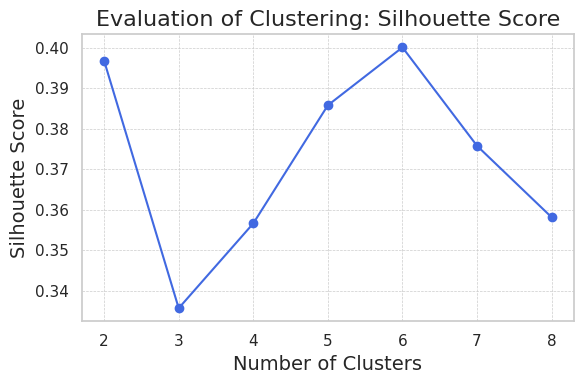

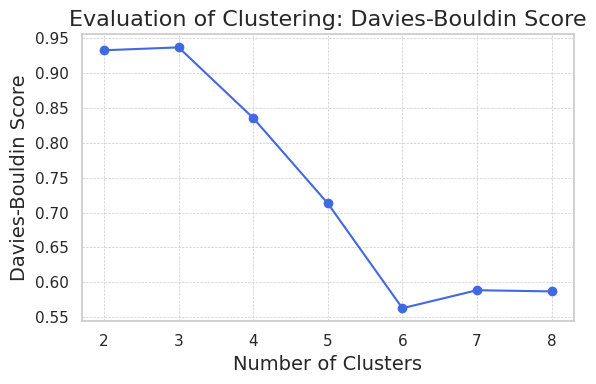

In [10]:
random_states = np.random.randint(0, 1000000, 100)

_, silhouette_scores, db_scores = evaluate_clustering(
    df_filtered, random_states=random_states
)
optimal_clusters_silhouette = find_optimal_silhouette(silhouette_scores)
optimal_clusters_davies_bouldin = find_optimal_davies_bouldin(db_scores)

print(f"Optimal number of clusters by Silhouette Method: {optimal_clusters_silhouette}")
print(
    f"Optimal number of clusters by Davies-Bouldin Method: {optimal_clusters_davies_bouldin}"
)
plot_metric(silhouette_scores, "Silhouette Score", start=2, ylabel="Silhouette Score")
plot_metric(db_scores, "Davies-Bouldin Score", start=2, ylabel="Davies-Bouldin Score")

In [11]:
# Select the optimal number of clusters
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(df_filtered)

# Map the cluster assignments back to the original dataset
data["Cluster"] = -1  # Initialize all data points as outliers
non_outlier_indices = np.where(outliers == 1)[0]
data.loc[data.index.to_numpy()[non_outlier_indices], "Cluster"] = clusters

# Assign outliers to the nearest cluster
outlier_indices = np.where(outliers == -1)[0]
for idx in data.index.to_numpy()[outlier_indices]:
    point = df_pca.loc[idx].to_numpy().reshape(1, -1)
    nearest_cluster = kmeans.predict(point)[0]
    data.loc[idx, "Cluster"] = nearest_cluster

/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
for cluster_num in range(optimal_clusters):
    print(f"Datasets in Cluster {cluster_num}:")
    cluster_data = data[data["Cluster"] == cluster_num].index.to_numpy()
    print(cluster_data)
    print("\n")

Datasets in Cluster 0:
['amazon_cds' 'amazon_tv' 'gowalla' 'mts_library' 'amazon_mi' 'yelp']


Datasets in Cluster 1:
['beeradvocate' 'dianping' 'douban_movies' 'movielens_1m' 'reddit' 'rekko']


Datasets in Cluster 2:
['movielens_10m' 'movielens_20m' 'ratebeer']


Datasets in Cluster 3:
['amazon_finefoods' 'brightkite' 'douban_books' 'douban_music' 'epinions'
 'food' 'goodreads' 'retail' 'tafeng']


Datasets in Cluster 4:
['foursquare' 'kuairec_full' 'kuairec_small']


Datasets in Cluster 5:
['netflix' 'sber_smm' 'sber_zvuk']




In [13]:
# Calculate distances from each point to its cluster centroid
distances_to_centroid = euclidean_distances(df_filtered, kmeans.cluster_centers_)
closest_points = np.argmin(distances_to_centroid, axis=0)

# Print the closest dataset to the centroid of each cluster
for i, index in enumerate(closest_points):
    dataset_name = df_filtered.index[
        index
    ]  # Assuming df_filtered has preserved the original index
    print(f"Closest dataset to the centroid of Cluster {i}: {dataset_name}")

Closest dataset to the centroid of Cluster 0: amazon_cds
Closest dataset to the centroid of Cluster 1: rekko
Closest dataset to the centroid of Cluster 2: movielens_20m
Closest dataset to the centroid of Cluster 3: tafeng
Closest dataset to the centroid of Cluster 4: foursquare
Closest dataset to the centroid of Cluster 5: sber_zvuk


In [14]:
data.loc[["amazon_cds", "rekko", "movielens_20m", "tafeng", "foursquare", "sber_zvuk"]]

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,APB,StPB,SkPB,KuPB,LTavg,LTstd,LTsk,LTku,Cluster
amazon_cds,69394,116073,1178506,8054769762,0.597848,0.000146,16.982823,10.153145,0.488385,0.517409,0.001067,0.001119,2.485566,8.821879,0.218731,0.159860,0.868915,1.073294,0
rekko,19362,4326,219335,83760012,4.475728,0.002619,11.328117,50.701572,0.721498,0.374776,0.024555,0.014047,0.911885,0.891251,0.165918,0.169051,1.179554,1.574779,1
movielens_20m,125682,13993,11168872,1758668226,8.981777,0.006351,88.866122,798.175659,0.853317,0.580757,0.102968,0.045278,0.886282,1.066021,0.133172,0.131848,1.469088,2.794798,2
tafeng,25258,15610,700464,394277380,1.618065,0.001777,27.732362,44.872774,0.656439,0.459436,0.013792,0.010479,2.508496,9.777250,0.196769,0.152126,1.105602,1.886238,3
foursquare,1078,366,51222,394548,2.945355,0.129825,47.515770,139.950820,0.569234,0.199233,0.312208,0.034858,0.021090,1.664028,0.192784,0.069017,0.494529,1.822821,4
sber_zvuk,165534,106943,38523177,17702702562,1.547871,0.002176,232.720631,360.221585,0.676589,0.466682,0.029200,0.022528,1.395420,2.672575,0.186897,0.155762,1.233788,1.476543,5


In [15]:
# Analyze the clusters based on the original features
cluster_analysis = data.groupby("Cluster").mean()
print(cluster_analysis)

                    Nu             Ni            Nr     SpaceSize     Shape  \
Cluster                                                                       
0         73718.500000  116921.500000  1.472491e+06  8.947235e+09  0.732323   
1         17488.166667    8795.833333  6.567550e+05  1.570212e+08  2.463844   
2         66655.333333   16617.333333  5.981787e+06  8.625930e+08  5.564331   
3         22128.888889   31411.333333  4.941551e+05  1.363397e+09  0.708956   
4          3221.666667    4082.333333  3.810866e+06  2.254182e+07  1.405442   
5        262583.666667   97453.666667  3.987377e+07  1.877855e+10  9.145570   

          Density          Rpu          Rpi     Ginii     Giniu       APB  \
Cluster                                                                     
0        0.000251    22.907445    12.260396  0.466222  0.535053  0.000988   
1        0.010644    83.115876    83.063307  0.681790  0.520647  0.059030   
2        0.007053   105.463597   487.461236  0.803446  0.64

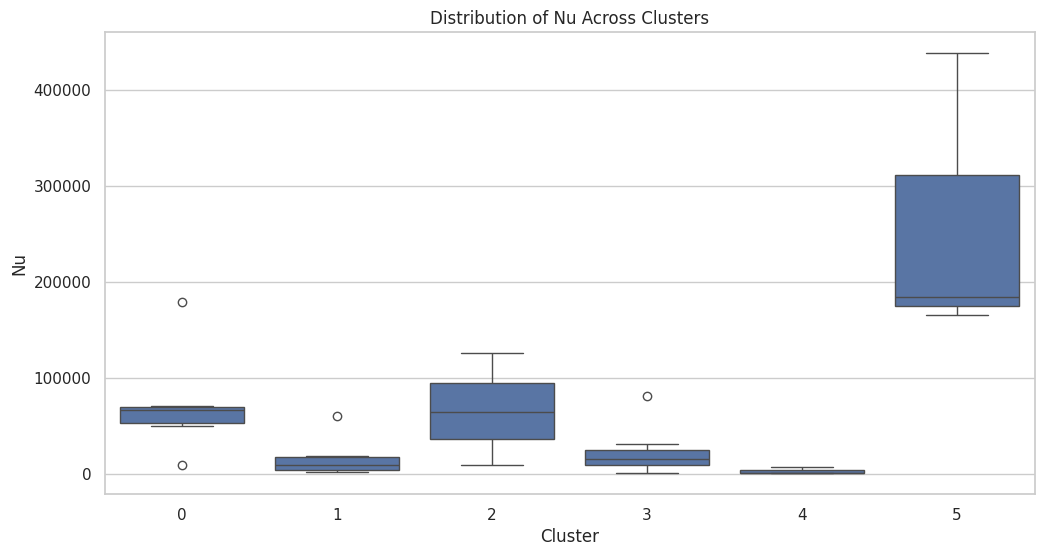

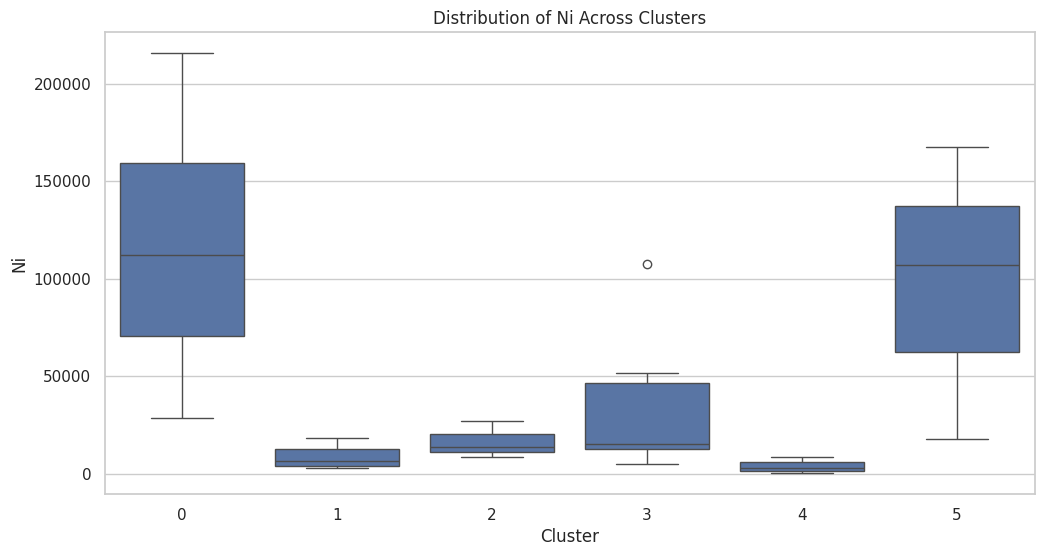

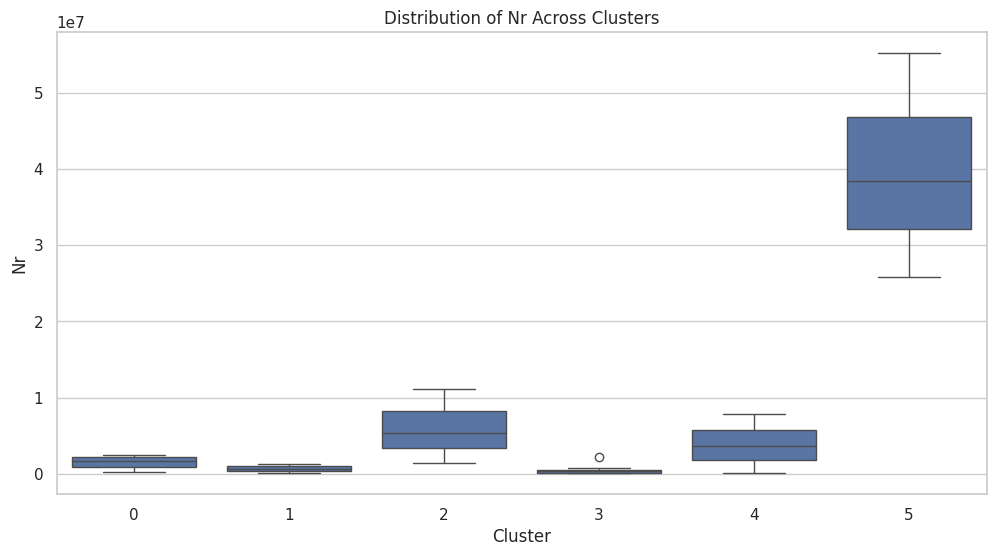

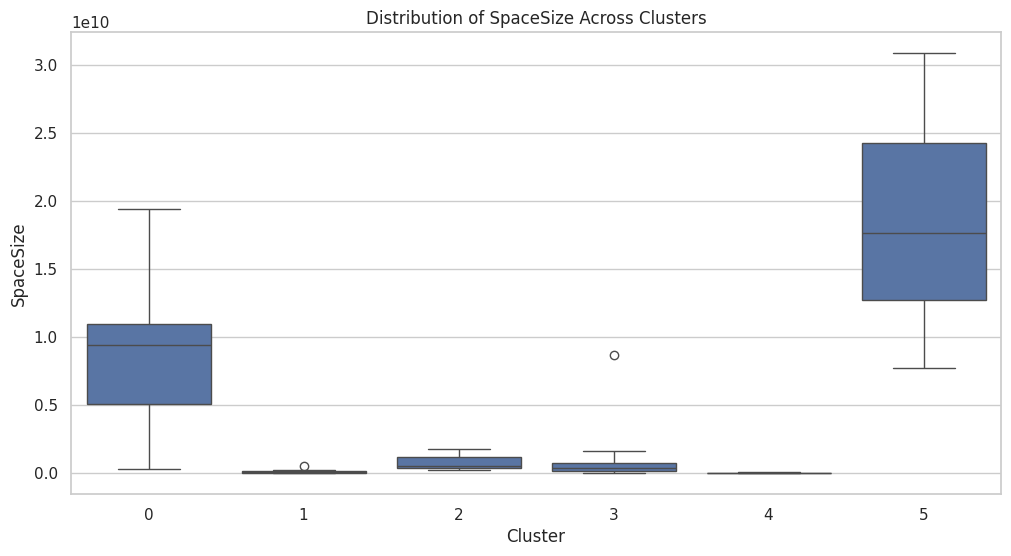

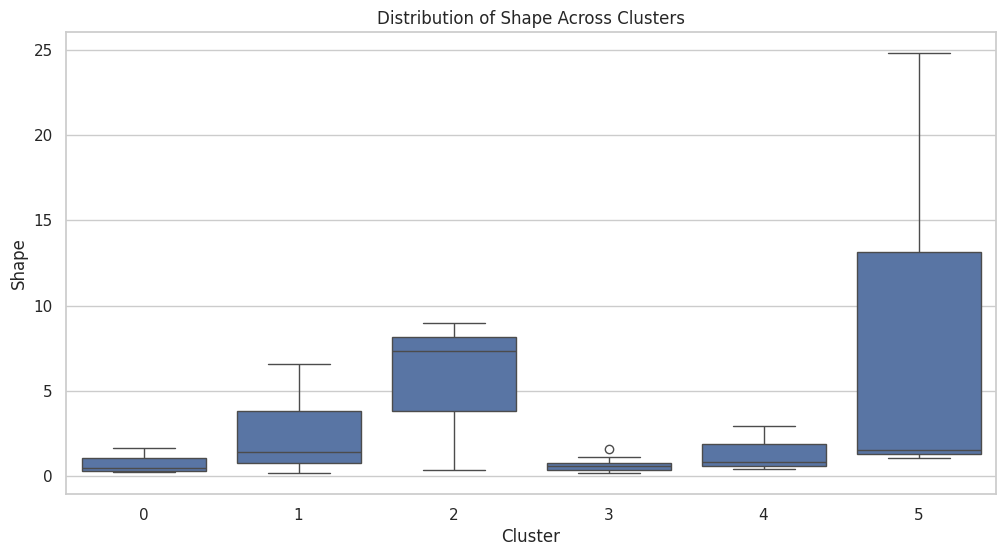

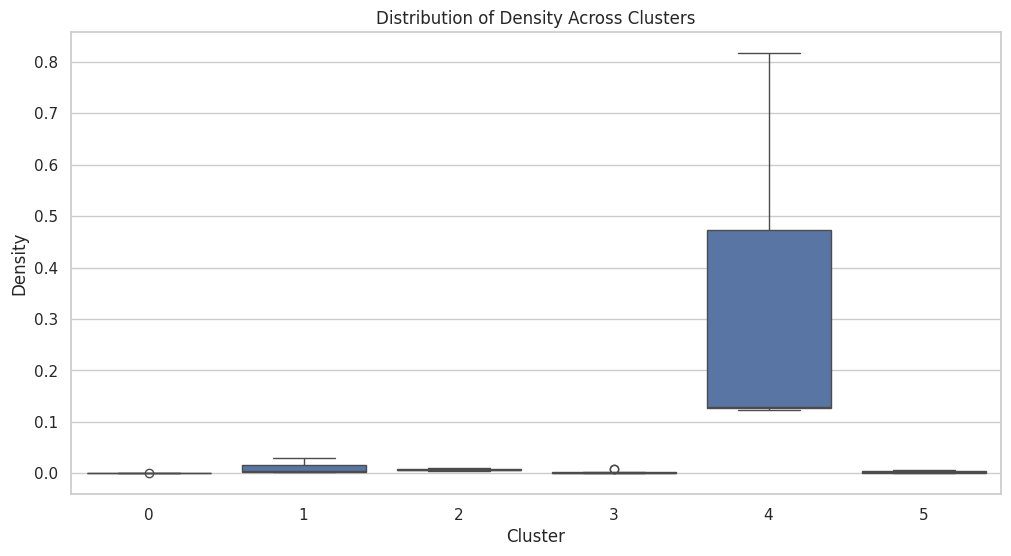

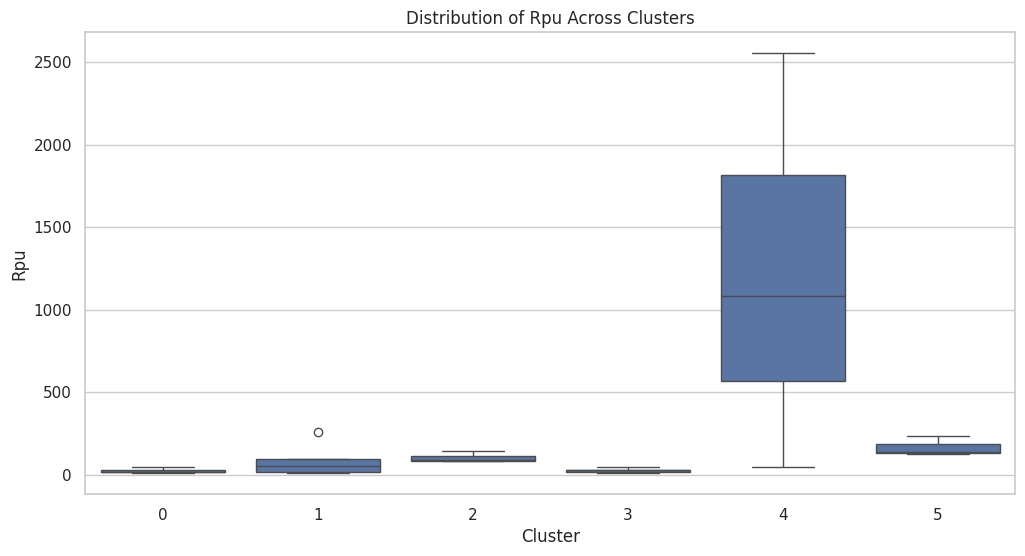

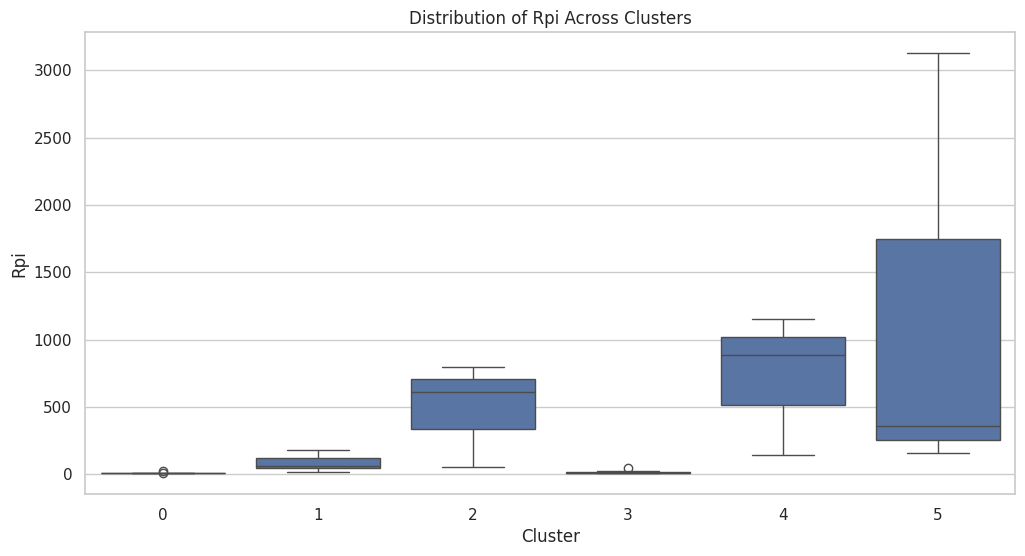

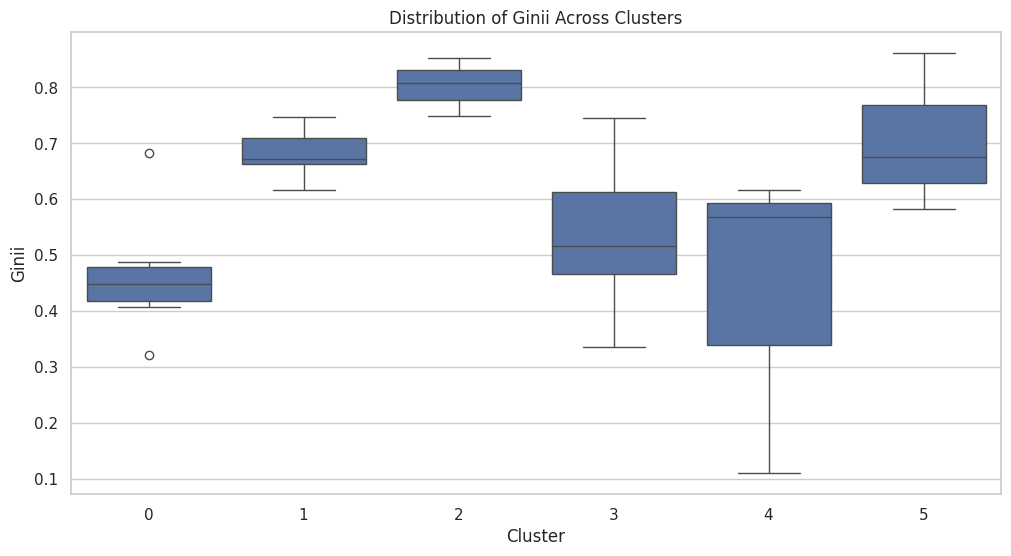

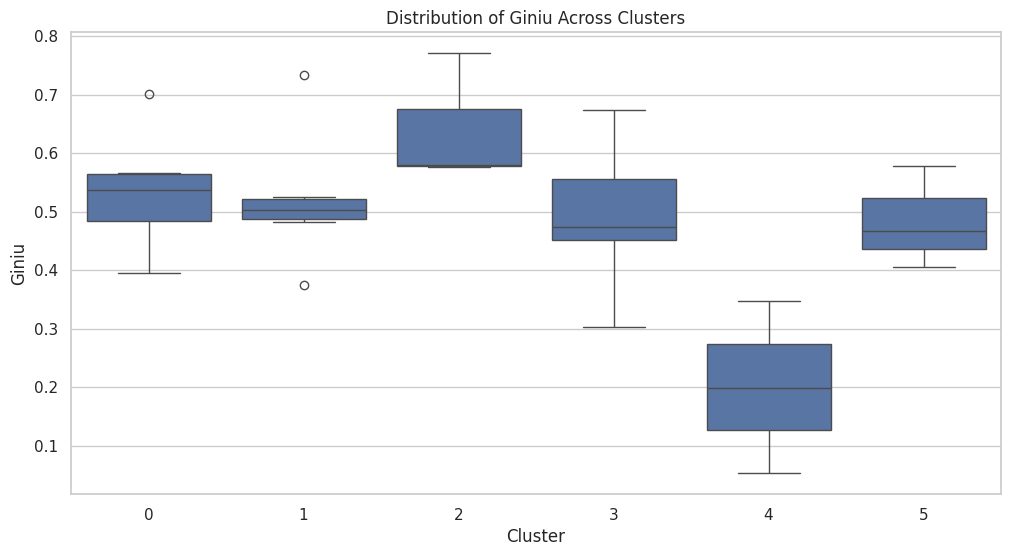

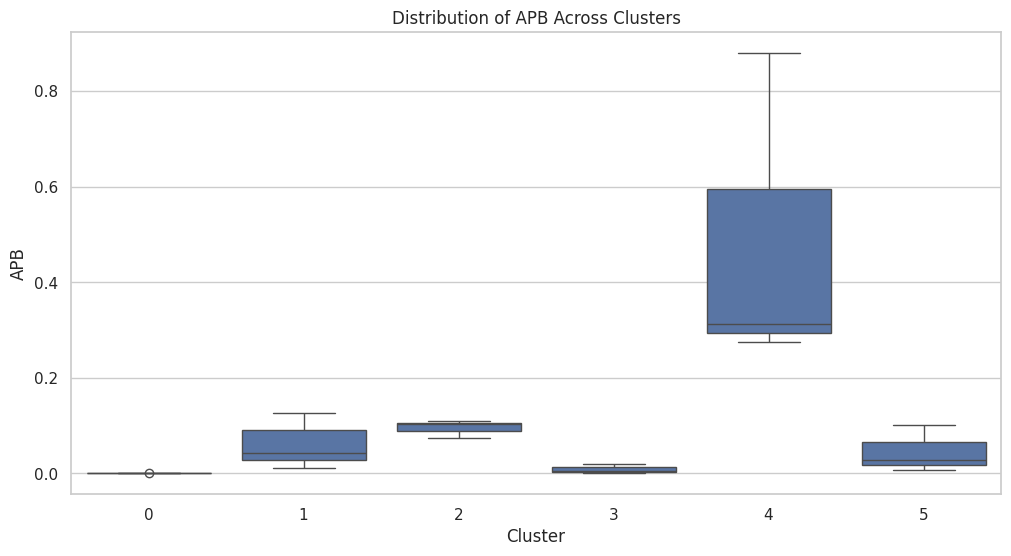

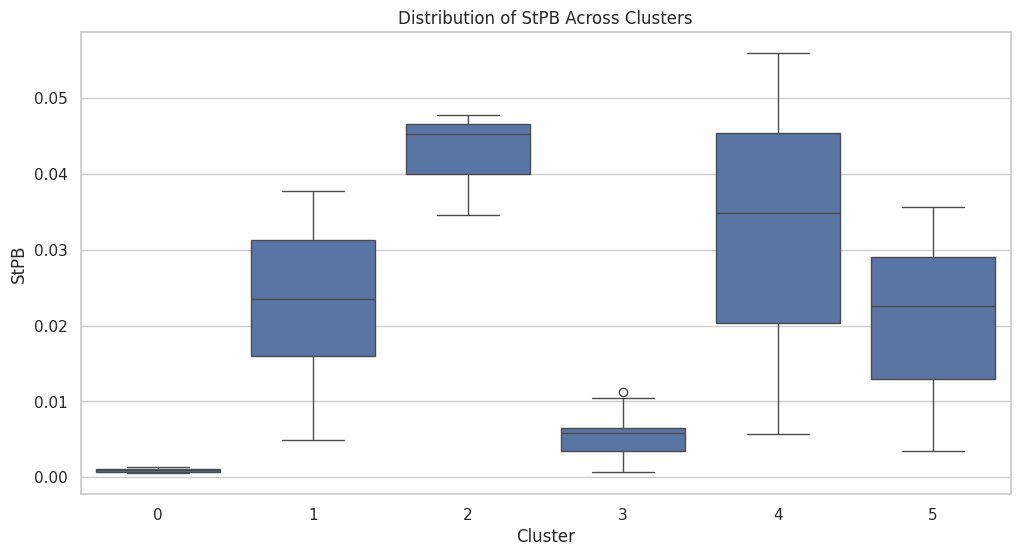

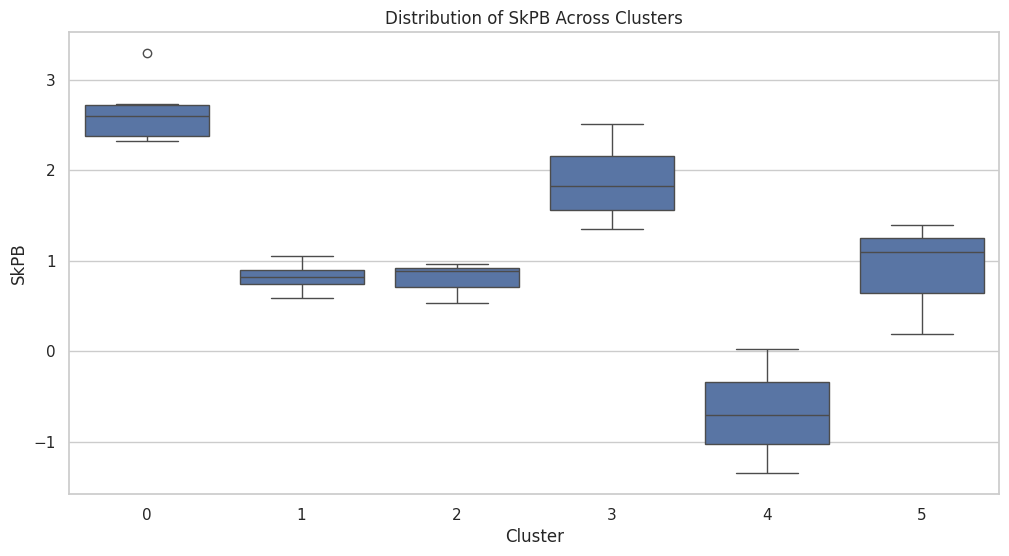

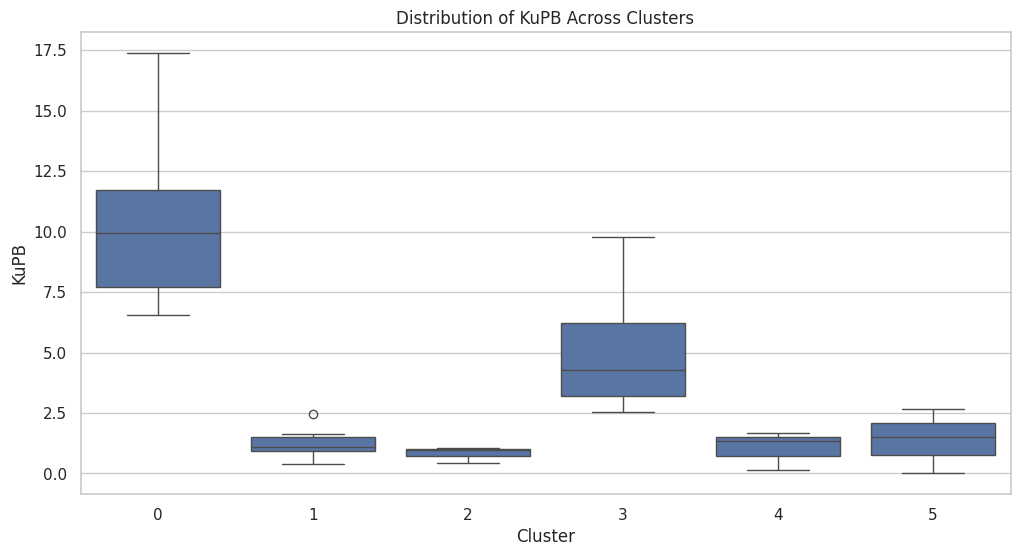

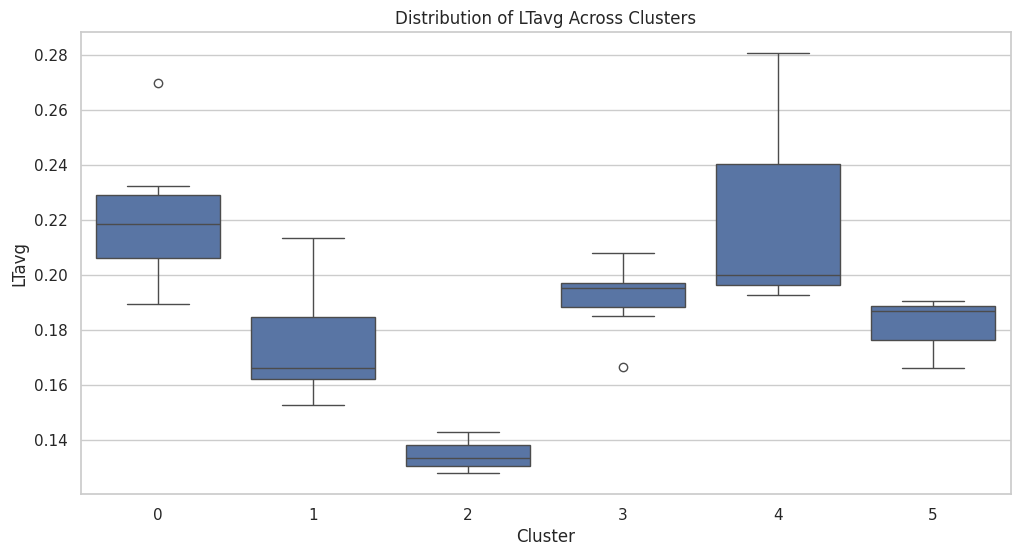

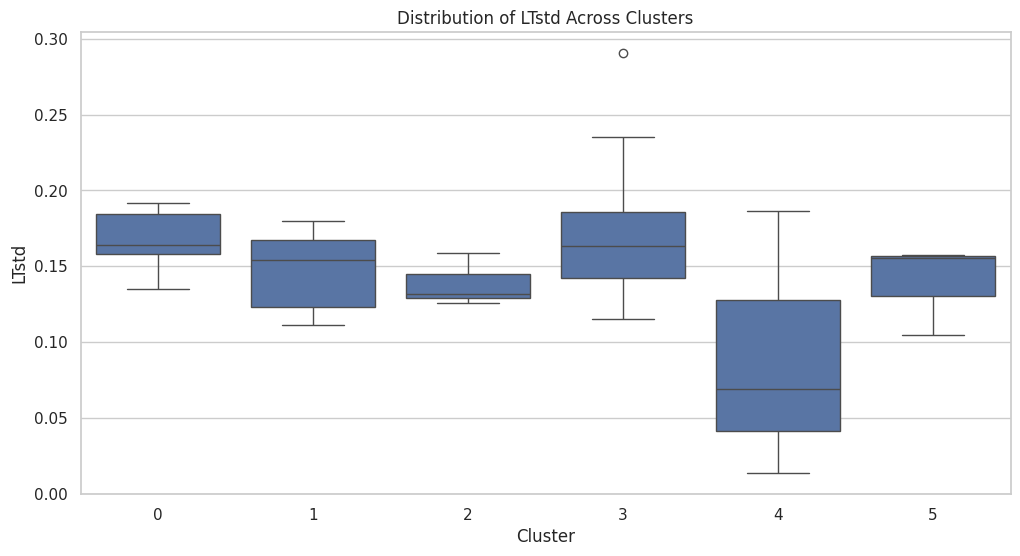

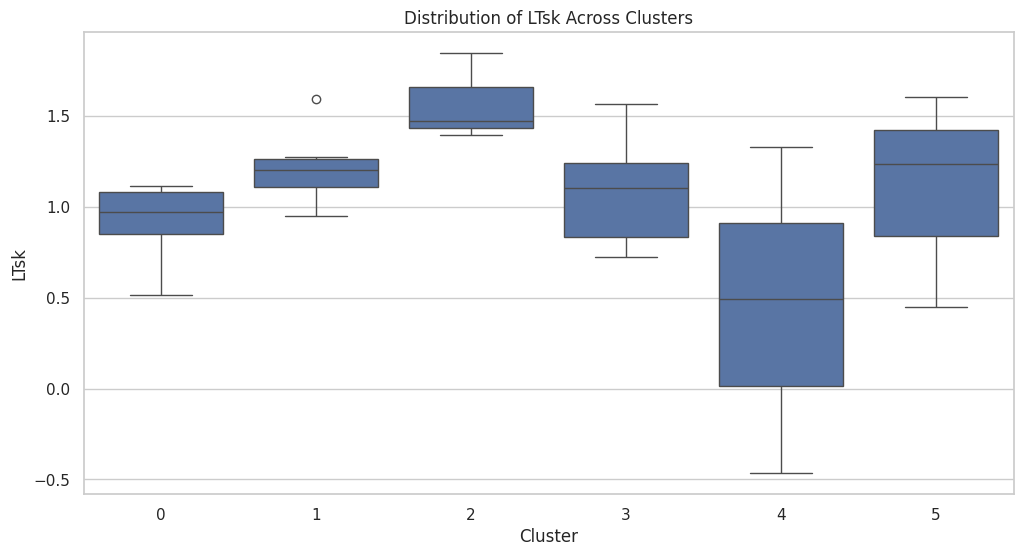

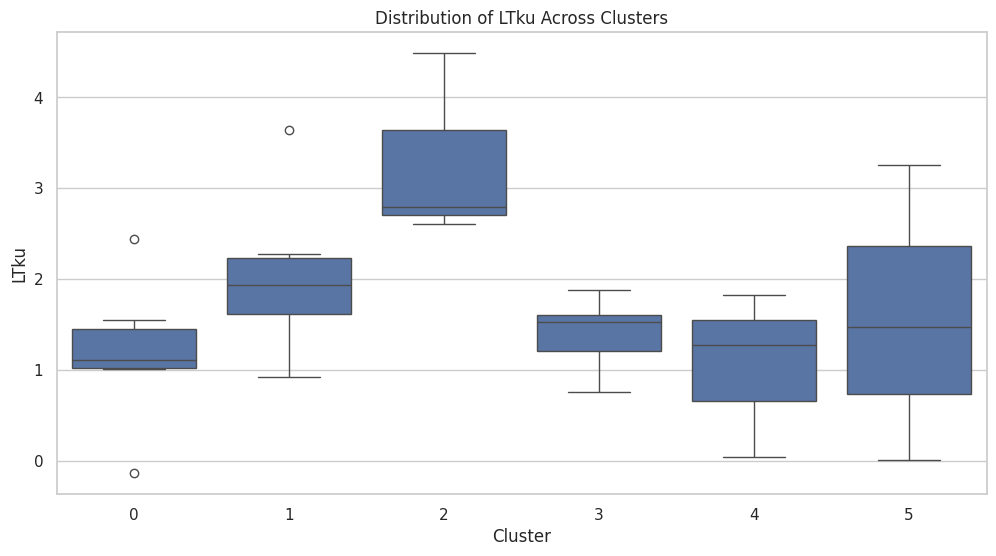

In [16]:
# Assuming 'data' contains the full dataset with original features and 'Cluster' labels assigned
clusters = data["Cluster"].unique()

# Visualizing feature distributions for each cluster
for feature in data.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Cluster", y=feature, data=data)
    plt.title(f"Distribution of {feature} Across Clusters")
    plt.show()

In [17]:
cluster_analysis_norm = pd.DataFrame(
    MinMaxScaler().fit_transform(cluster_analysis),
    cluster_analysis.index,
    cluster_analysis.columns,
)
columns_to_scale = data.columns.difference(["Cluster"])
scaler = MinMaxScaler()
data_norm = pd.DataFrame(
    scaler.fit_transform(data[columns_to_scale]),
    columns=columns_to_scale,
    index=data.index,
)
data_norm["Cluster"] = data["Cluster"]

Cluster 0 Analysis:
Nu           0.271809
Ni           1.000000
Nr           0.024844
SpaceSize    0.475831
Shape        0.002770
Density      0.000000
Rpu          0.000000
Rpi          0.000000
Ginii        0.092030
Giniu        0.756379
APB          0.000000
StPB         0.000000
SkPB         1.000000
KuPB         1.000000
LTavg        0.970646
LTstd        0.905524
LTsk         0.415073
LTku         0.058543
Name: 0, dtype: float64




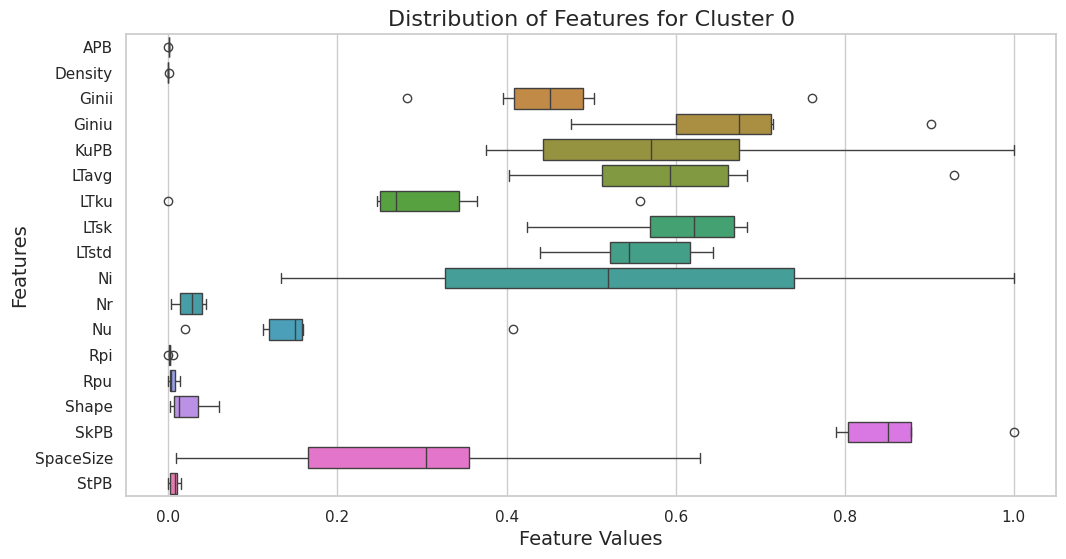

Cluster 1 Analysis:
Nu           0.055006
Ni           0.041772
Nr           0.004129
SpaceSize    0.007170
Shape        0.208009
Density      0.029151
Rpu          0.049945
Rpi          0.058922
Ginii        0.672444
Giniu        0.723862
APB          0.118926
StPB         0.525823
SkPB         0.450715
KuPB         0.044635
LTavg        0.448409
LTstd        0.672653
LTsk         0.684597
LTku         0.444572
Name: 1, dtype: float64




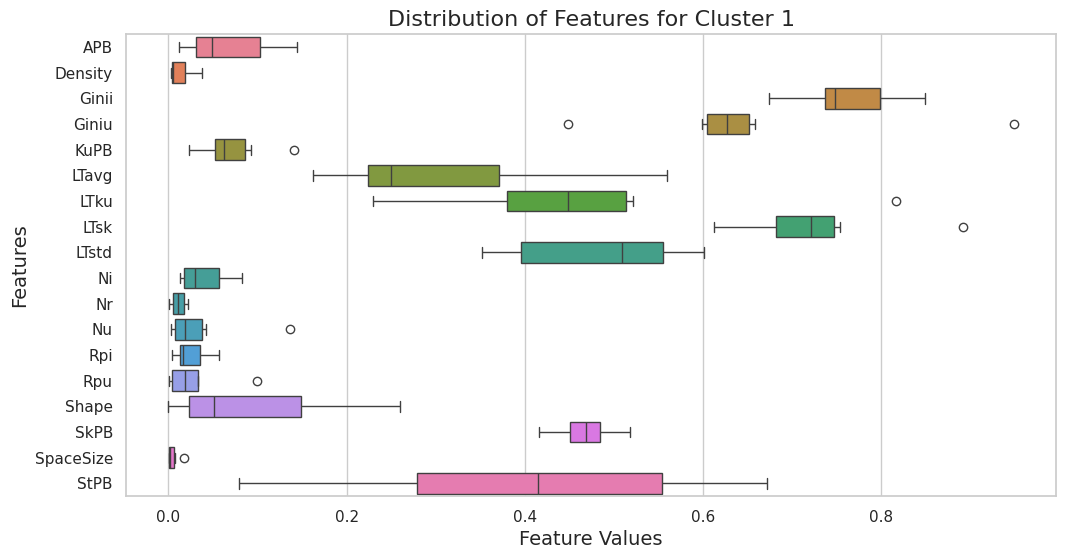

Cluster 2 Analysis:
Nu           0.244576
Ni           0.111087
Nr           0.139352
SpaceSize    0.044788
Shape        0.575512
Density      0.019078
Rpu          0.068483
Rpi          0.395460
Ginii        1.000000
Giniu        1.000000
APB          0.193644
StPB         1.000000
SkPB         0.443015
KuPB         0.000000
LTavg        0.000000
LTstd        0.572816
LTsk         1.000000
LTku         1.000000
Name: 2, dtype: float64




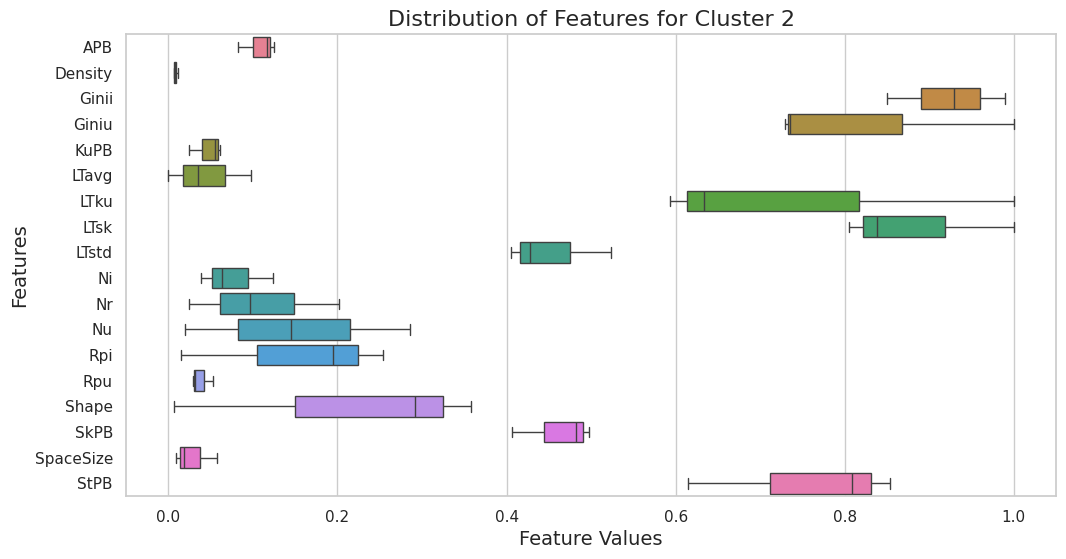

Cluster 3 Analysis:
Nu           0.072899
Ni           0.242194
Nr           0.000000
SpaceSize    0.071489
Shape        0.000000
Density      0.006248
Rpu          0.002161
Rpi          0.002743
Ginii        0.269282
Giniu        0.674999
APB          0.015470
StPB         0.111403
SkPB         0.758467
KuPB         0.452268
LTavg        0.646974
LTstd        1.000000
LTsk         0.559066
LTku         0.159370
Name: 3, dtype: float64




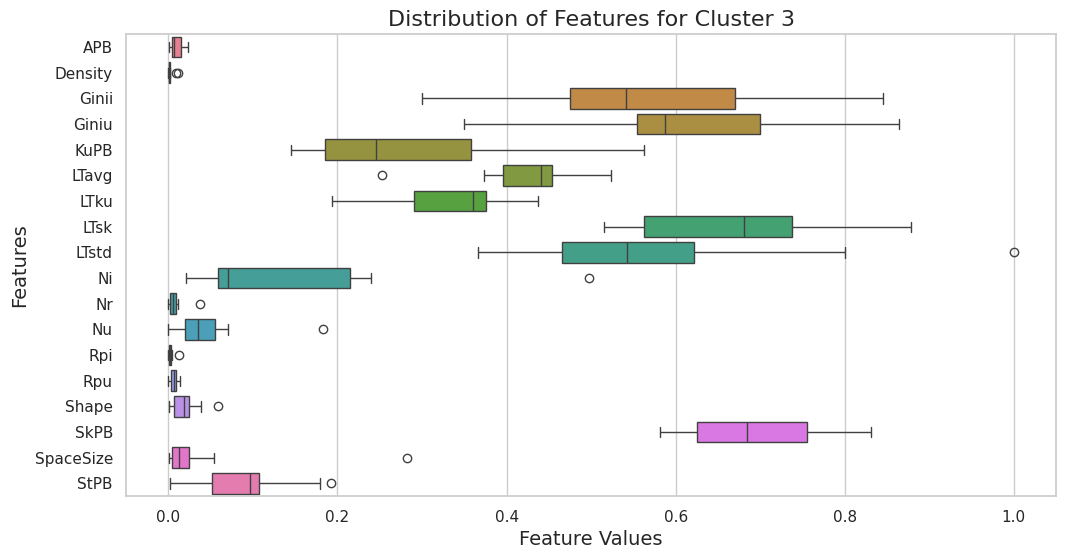

Cluster 4 Analysis:
Nu           0.000000
Ni           0.000000
Nr           0.084224
SpaceSize    0.000000
Shape        0.082555
Density      1.000000
Rpu          1.000000
Rpi          0.594750
Ginii        0.000000
Giniu        0.000000
APB          1.000000
StPB         0.750763
SkPB         0.000000
KuPB         0.023093
LTavg        1.000000
LTstd        0.000000
LTsk         0.000000
LTku         0.000000
Name: 4, dtype: float64




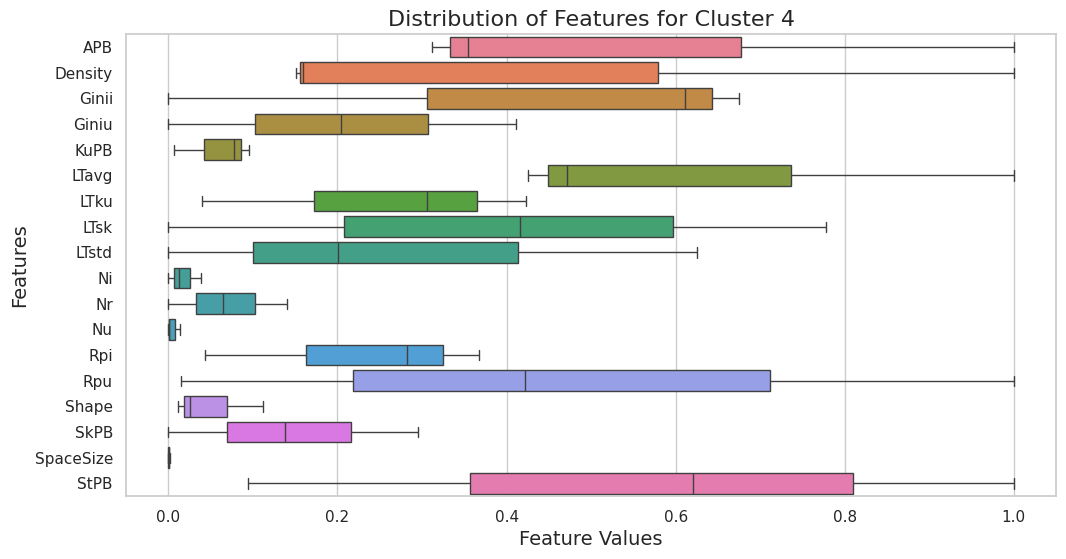

Cluster 5 Analysis:
Nu           1.000000
Ni           0.827473
Nr           1.000000
SpaceSize    1.000000
Shape        1.000000
Density      0.008788
Rpu          0.119022
Rpi          1.000000
Ginii        0.740692
Giniu        0.640750
APB          0.090999
StPB         0.470967
SkPB         0.472775
KuPB         0.058893
LTavg        0.517979
LTstd        0.578504
LTsk         0.576035
LTku         0.235461
Name: 5, dtype: float64




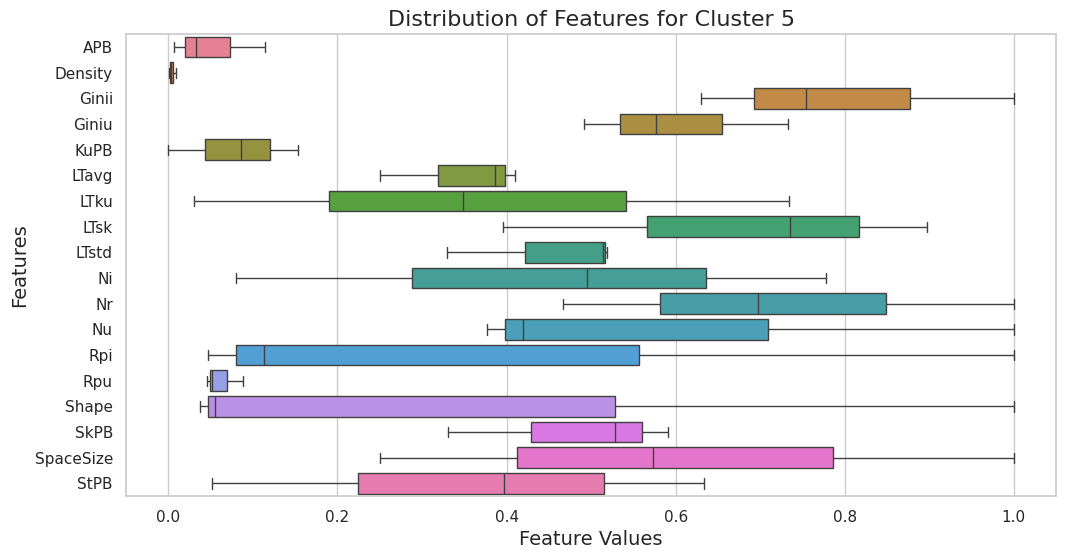

In [18]:
# Print and visualize the analysis of each cluster
for cluster_num, cluster_data in cluster_analysis_norm.iterrows():
    print(f"Cluster {cluster_num} Analysis:")
    print(cluster_data)
    print("\n")

    # Visualize the distribution of features for this cluster
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=data_norm[data_norm["Cluster"] == cluster_num].drop(columns="Cluster"),
        orient="h",
    )
    plt.title(f"Distribution of Features for Cluster {cluster_num}", fontsize=16)
    plt.xlabel("Feature Values", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.show()